<a href="https://colab.research.google.com/github/fridriscvski/weeds-segmentation/blob/main/cornweeds_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U segmentation-models-pytorch
!pip install  --force-reinstall albumentations 1.4.0

!pip uninstall pretrainedmodels -y
!pip uninstall efficientnet-pytorch -y
!pip uninstall timm -y

!pip install timm==0.9.12
!pip install pretrainedmodels>=0.7.4
!pip install efficientnet-pytorch>=0.7.1
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np
import os
import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
import albumentations as albu
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
from albumentations.pytorch import ToTensorV2
from matplotlib.colors import LinearSegmentedColormap

## Helper functions

In [ ]:
colors = [
    (0,0,0),                        # background
    (155/255, 210/255, 10/255),     # corns
    (255/255, 111/255, 97/255),     # Amaranthus hybridos
    (255/255, 215/255, 0/255),      # Cyclospermum leptophyllum
    (64/255, 224/255, 208/255),     # Tridax procumbens
    (147/255, 112/255, 219/255),    # Sonchus oleraceus
    (0/255, 255/255, 0/255),        # Bidens-pilosa
    (255/255, 69/255, 0/255),       # Lelidium virginum
    (135/255, 206/255, 235/255),    # Ipomoeae purpurea
    (138/255, 43/255, 226/255),     # Leonurus sibiricus
    (255/255, 20/255, 147/255),     # Sorghum arundinaceum
    (50/255, 205/255, 50/255),      # Rhynchelytrumrepens
    (186/255, 85/255, 211/255),     # Digitaria insularis
    (255/255, 99/255, 71/255),      # Choris barbata
    (0/255, 206/255, 209/255),      # Cenchus echinatus
    (139/255, 69/255, 19/255)       # Physalis angulata
]

# Define positions
positions = np.linspace(0, 1, len(colors))

# Create colormap
cmap = LinearSegmentedColormap.from_list('CustomCmap', list(zip(positions, colors)))

def convert_visualizable_mask(mask):
    combined_mask = np.zeros((mask.shape[1], mask.shape[2]))
    for channel in range(mask.shape[0]):
        combined_mask[mask[channel, :, :] == 1] = channel

    return combined_mask

## Training model

In [ ]:
import os

DATASET_PATH = 'drive/My Drive/TCC/cropped_corn_weeds'
TRAIN_DATASET_PATH = os.path.join(DATASET_PATH, 'train')
TEST_DATASET_PATH = os.path.join(DATASET_PATH, 'test')
VAL_DATASET_PATH = os.path.join(DATASET_PATH, 'validation')

In [ ]:
print(f"Train set: {len(os.listdir(os.path.join(TRAIN_DATASET_PATH, 'images')))} samples")
print(f"Test set: {len(os.listdir(os.path.join(TEST_DATASET_PATH, 'images')))} samples")
print(f"Validation set: {len(os.listdir(os.path.join(VAL_DATASET_PATH, 'images')))} samples")

Train set: 17476 samples
Test set: 3846 samples
Validation set: 3754 samples


In [ ]:
class CornWeedsDataset(Dataset):
    CLASSES = [
        "background", "corns", "amaranthus hybridos", "cyclospermum leptophyllum", "tridax procumbens",
        "sonchus oleraceus", "bidens-pilosa", "lelidium virginum", "ipomoeae purpurea",
        "leonurus sibiricus", "sorghum arundinaceum", "rhynchelytrumrepens", "digitaria insularis",
        "choris barbata", "cenchus echinatus", "physalis angulata"
    ]

    def __init__(
        self,
        images_dir,
        annotations_dir,
        classes=None,
        preprocessing=None,
        transform=None
  ):
        self.ids = os.listdir(images_dir)
        self.images = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.annotations = [os.path.join(annotations_dir, image_id) for image_id in self.ids]
        self.preprocessing = preprocessing
        self.transform = transform

        if classes:
            self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        else:
            self.class_values = np.arange(0, len(CornWeedsDataset.CLASSES))

    def __getitem__(self, i):
        image = cv2.imread(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.annotations[i], cv2.IMREAD_GRAYSCALE)

        # mask = np.zeros((simple_mask.shape[0], simple_mask.shape[1], len(self.class_values)))
        # for class_value in self.class_values:
        #     mask[:, :, class_value] = (simple_mask == class_value).astype(float)

        if self.transform is not None:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.images)

In [ ]:
test_transform = albu.Compose([
    albu.PadIfNeeded(min_height=256, min_width=256, border_mode=4),
    albu.Resize(256, 256),
    ToTensorV2(),
])

train_transform = albu.Compose([
    albu.PadIfNeeded(min_height=256, min_width=256, border_mode=4),
    albu.Resize(256, 256),
    albu.RandomBrightnessContrast(),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.MedianBlur(blur_limit=3, p=0.1, always_apply=False),
    ToTensorV2(),
])

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
ENCODER = 'resnet152'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = CornWeedsDataset(
    os.path.join(TRAIN_DATASET_PATH, 'images'),
    os.path.join(TRAIN_DATASET_PATH, 'annotations'),
    classes=None,
    preprocessing=get_preprocessing(preprocessing_fn),
    transform=train_transform
)

val_dataset = CornWeedsDataset(
    os.path.join(VAL_DATASET_PATH, 'images'),
    os.path.join(VAL_DATASET_PATH, 'annotations'),
    classes=None,
    preprocessing=get_preprocessing(preprocessing_fn),
    transform=test_transform
)

test_dataset = CornWeedsDataset(
    os.path.join(TEST_DATASET_PATH, 'images'),
    os.path.join(TEST_DATASET_PATH, 'annotations'),
    classes=None,
    preprocessing=get_preprocessing(preprocessing_fn),
    transform=test_transform
)

n_workers = os.cpu_count()
batch_size = 8

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, num_workers=n_workers)

val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                              shuffle=False, num_workers=n_workers)

test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                               shuffle=False, num_workers=n_workers)

image: torch.Size([3, 256, 256]) - mask: torch.Size([256, 256])


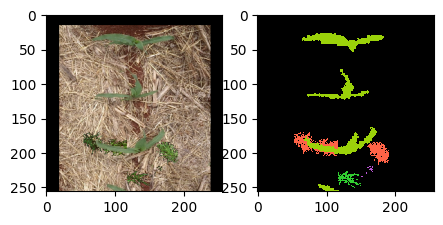

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
img, mask = test_dataset[200]
print(f'image: {img.shape} - mask: {mask.shape}')

_, axis = plt.subplots(1,2, figsize=(5,7))
axis[0].imshow(img.permute(1,2,0))
axis[1].imshow(mask, cmap=cmap, vmin=0, vmax=len(colors)-1, interpolation='nearest')

In [ ]:
class AvageraMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]


## Focal Loss

In [ ]:
from tqdm import tqdm as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ACTIVATION = None
MODE: str = 'multiclass'
LEARNING_RATE = 1e-4

loss = smp.losses.FocalLoss(mode=MODE)

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels = 3,
    classes=len(CornWeedsDataset.CLASSES),
    activation=ACTIVATION
)

model.to(DEVICE)
num_classes = 16
iou_fn = MulticlassJaccardIndex(num_classes=num_classes, average=None).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss_meter = AvageraMeter()
val_loss_meter = AvageraMeter()
acc_meter = AvageraMeter()
iou_meter = AvageraMeter()
best_acc = 0

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:00<00:00, 297MB/s]


In [ ]:
for epoch in range(35):
    train_loss_meter.reset()
    val_loss_meter.reset()
    acc_meter.reset()

    for i, (inputs, labels) in enumerate(tqdm(train_data_loader)):
        optimizer.zero_grad()

        n = inputs.shape[1]
        inputs = inputs.to(DEVICE).float()
        labels = labels.to(DEVICE).float()

        outputs = model(inputs)
        labels = labels.squeeze()

        loss = smp.losses.FocalLoss(mode=MODE)(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            active_output = outputs.sigmoid().round().long()
            active_output = active_output.argmax(dim=1)
            train_loss_meter.update(loss.item(), n)
            acc_meter.update(accuracy_function(active_output, labels.long()), n)
            iou_meter.update(iou_fn(active_output, labels.long()), n)

    print(f'epoch: {epoch}; loss: {train_loss_meter.avg}; accuracy: {acc_meter.avg}; iou: {iou_meter.avg}')

    if acc_meter.avg > best_acc:
        best_acc = acc_meter.avg
        print("saving model")
        torch.save(model.state_dict(), f'unet_fl_cropped_model.pth')

100%|██████████| 2185/2185 [04:40<00:00,  7.80it/s]


epoch: 0; loss: 0.38214353251375377; accuracy: 0.9069889187812805; iou: tensor([9.2222e-01, 5.5287e-02, 9.5387e-05, 2.8181e-04, 8.8797e-03, 4.8136e-03,
        7.8627e-02, 3.9296e-04, 4.9634e-03, 9.2254e-03, 9.3324e-03, 7.8521e-03,
        6.7918e-04, 1.9022e-02, 1.4222e-02, 4.1334e-03], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:37<00:00,  7.87it/s]


epoch: 1; loss: 0.1595032231912051; accuracy: 0.9138986468315125; iou: tensor([9.2602e-01, 4.8872e-02, 6.9830e-04, 8.8007e-03, 3.1737e-02, 2.6670e-03,
        1.0789e-01, 1.4343e-02, 2.7047e-02, 1.7031e-02, 7.1154e-02, 2.8504e-02,
        3.6619e-03, 1.0484e-01, 3.2075e-02, 2.8681e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:37<00:00,  7.88it/s]


epoch: 2; loss: 0.12649075716597538; accuracy: 0.9213336110115051; iou: tensor([9.2697e-01, 6.9336e-02, 7.9196e-04, 6.0763e-02, 4.7722e-02, 1.7858e-03,
        1.2447e-01, 4.9767e-02, 6.6559e-02, 4.2174e-02, 1.2680e-01, 5.4325e-02,
        4.1997e-02, 1.8014e-01, 4.2572e-02, 5.6653e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:39<00:00,  7.82it/s]


epoch: 3; loss: 0.11037954085546992; accuracy: 0.9240686297416687; iou: tensor([9.2696e-01, 9.9111e-02, 7.1554e-04, 8.3819e-02, 4.5419e-02, 1.3478e-03,
        1.4842e-01, 8.6345e-02, 7.9291e-02, 4.4013e-02, 1.2931e-01, 8.3478e-02,
        7.8356e-02, 2.1037e-01, 6.1301e-02, 5.3347e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:37<00:00,  7.87it/s]


epoch: 4; loss: 0.09818726788260025; accuracy: 0.9278321266174316; iou: tensor([9.2705e-01, 1.4776e-01, 6.0161e-04, 8.4460e-02, 3.7113e-02, 1.0841e-03,
        1.5054e-01, 1.2859e-01, 7.9932e-02, 3.6477e-02, 1.1290e-01, 1.0376e-01,
        9.7686e-02, 2.0628e-01, 6.8133e-02, 4.3691e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:38<00:00,  7.86it/s]


epoch: 5; loss: 0.09087070043047452; accuracy: 0.9296902418136597; iou: tensor([9.2729e-01, 1.9573e-01, 5.0915e-04, 8.5951e-02, 3.1059e-02, 9.0396e-04,
        1.3977e-01, 1.4896e-01, 8.0467e-02, 3.0861e-02, 9.9705e-02, 1.0602e-01,
        1.0306e-01, 1.9077e-01, 6.9803e-02, 3.7301e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:37<00:00,  7.86it/s]


epoch: 6; loss: 0.08486821426747866; accuracy: 0.9303255677223206; iou: tensor([9.2751e-01, 2.3550e-01, 4.3789e-04, 8.7781e-02, 2.6682e-02, 7.7513e-04,
        1.3036e-01, 1.5712e-01, 7.8663e-02, 2.7027e-02, 9.0308e-02, 9.7327e-02,
        1.0638e-01, 1.7384e-01, 6.5975e-02, 3.3913e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:39<00:00,  7.81it/s]


epoch: 7; loss: 0.07974912354240973; accuracy: 0.9302391409873962; iou: tensor([9.2764e-01, 2.6897e-01, 3.8396e-04, 8.9554e-02, 2.3358e-02, 6.7845e-04,
        1.2039e-01, 1.5722e-01, 7.6180e-02, 2.4035e-02, 8.1938e-02, 8.6129e-02,
        1.0476e-01, 1.5665e-01, 6.0492e-02, 3.1358e-02], device='cuda:0')


100%|██████████| 2185/2185 [04:42<00:00,  7.72it/s]


epoch: 8; loss: 0.07590552224208616; accuracy: 0.9310466647148132; iou: tensor([9.2783e-01, 2.9851e-01, 3.4164e-04, 8.9749e-02, 2.0768e-02, 6.0320e-04,
        1.1136e-01, 1.5582e-01, 7.2499e-02, 2.1605e-02, 7.4679e-02, 7.6850e-02,
        1.0302e-01, 1.4106e-01, 5.5302e-02, 2.9950e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:38<00:00,  7.85it/s]


epoch: 9; loss: 0.07342409174590962; accuracy: 0.9317106008529663; iou: tensor([9.2803e-01, 3.2539e-01, 3.0943e-04, 8.7200e-02, 1.8695e-02, 5.4299e-04,
        1.0221e-01, 1.5013e-01, 6.8207e-02, 1.9514e-02, 6.8703e-02, 6.9285e-02,
        1.0078e-01, 1.2809e-01, 5.0581e-02, 2.8133e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:37<00:00,  7.87it/s]


epoch: 10; loss: 0.0710723377406188; accuracy: 0.932403564453125; iou: tensor([9.2826e-01, 3.4916e-01, 2.8136e-04, 8.4152e-02, 1.6998e-02, 4.9370e-04,
        9.4430e-02, 1.4663e-01, 6.4366e-02, 1.7835e-02, 6.3669e-02, 6.3018e-02,
        9.7739e-02, 1.1724e-01, 4.6444e-02, 2.6611e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:36<00:00,  7.89it/s]


epoch: 11; loss: 0.06784011702515713; accuracy: 0.9325819611549377; iou: tensor([9.2846e-01, 3.7020e-01, 2.5797e-04, 8.0303e-02, 1.5584e-02, 4.5262e-04,
        8.7246e-02, 1.3948e-01, 6.0835e-02, 1.6443e-02, 5.9472e-02, 5.7794e-02,
        9.4902e-02, 1.0779e-01, 4.2794e-02, 2.5232e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:37<00:00,  7.87it/s]


epoch: 12; loss: 0.0664752879868383; accuracy: 0.9329150319099426; iou: tensor([9.2866e-01, 3.8905e-01, 2.3817e-04, 7.6248e-02, 1.4387e-02, 4.1784e-04,
        8.1414e-02, 1.3359e-01, 5.7180e-02, 1.5231e-02, 5.5593e-02, 5.3357e-02,
        9.0180e-02, 9.9834e-02, 3.9601e-02, 2.4134e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:37<00:00,  7.86it/s]


epoch: 13; loss: 0.06363149709931364; accuracy: 0.93316251039505; iou: tensor([9.2884e-01, 4.0601e-01, 2.2117e-04, 7.2089e-02, 1.3361e-02, 3.8803e-04,
        7.6214e-02, 1.2667e-01, 5.3585e-02, 1.4196e-02, 5.2088e-02, 4.9552e-02,
        8.5723e-02, 9.2851e-02, 3.6829e-02, 2.3289e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:36<00:00,  7.91it/s]


epoch: 14; loss: 0.06179258977691696; accuracy: 0.9336678981781006; iou: tensor([9.2903e-01, 4.2154e-01, 2.0645e-04, 6.8655e-02, 1.2471e-02, 3.6219e-04,
        7.1824e-02, 1.2053e-01, 5.0444e-02, 1.3305e-02, 4.8989e-02, 4.6254e-02,
        8.1927e-02, 8.6789e-02, 3.4438e-02, 2.2445e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:37<00:00,  7.88it/s]


epoch: 15; loss: 0.060313707977124154; accuracy: 0.9337173104286194; iou: tensor([9.2919e-01, 4.3541e-01, 1.9358e-04, 6.5163e-02, 1.1692e-02, 3.3958e-04,
        6.8011e-02, 1.1478e-01, 4.7615e-02, 1.2510e-02, 4.6101e-02, 4.3369e-02,
        7.7854e-02, 8.1492e-02, 3.2329e-02, 2.1519e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:38<00:00,  7.84it/s]


epoch: 16; loss: 0.0591151836125747; accuracy: 0.9341301321983337; iou: tensor([9.2937e-01, 4.4822e-01, 1.8226e-04, 6.2126e-02, 1.1005e-02, 3.1963e-04,
        6.4486e-02, 1.0996e-01, 4.5008e-02, 1.1835e-02, 4.3567e-02, 4.0822e-02,
        7.4048e-02, 7.6781e-02, 3.0447e-02, 2.1051e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:38<00:00,  7.83it/s]


epoch: 17; loss: 0.057003282356657754; accuracy: 0.9339271783828735; iou: tensor([9.2951e-01, 4.5952e-01, 1.7227e-04, 5.8952e-02, 1.0394e-02, 3.0189e-04,
        6.1164e-02, 1.0495e-01, 4.2608e-02, 1.1207e-02, 4.1356e-02, 3.8557e-02,
        7.0681e-02, 7.2569e-02, 2.8795e-02, 2.0309e-02], device='cuda:0')


100%|██████████| 2185/2185 [04:35<00:00,  7.92it/s]


epoch: 18; loss: 0.055065676676497304; accuracy: 0.9344205260276794; iou: tensor([9.2966e-01, 4.7035e-01, 1.6353e-04, 5.6075e-02, 9.8479e-03, 2.8601e-04,
        5.8092e-02, 1.0023e-01, 4.0471e-02, 1.0649e-02, 3.9296e-02, 3.6530e-02,
        6.7604e-02, 6.8825e-02, 2.7298e-02, 1.9577e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:36<00:00,  7.91it/s]


epoch: 19; loss: 0.054772979125926095; accuracy: 0.9345939755439758; iou: tensor([9.2980e-01, 4.8022e-01, 1.5561e-04, 5.3581e-02, 9.3559e-03, 2.7172e-04,
        5.5291e-02, 9.6196e-02, 3.8502e-02, 1.0145e-02, 3.7506e-02, 3.4711e-02,
        6.4624e-02, 6.5425e-02, 2.5969e-02, 1.9297e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:36<00:00,  7.91it/s]


epoch: 20; loss: 0.05294126591962726; accuracy: 0.9346342086791992; iou: tensor([9.2994e-01, 4.8926e-01, 1.4833e-04, 5.1276e-02, 8.9108e-03, 2.5879e-04,
        5.2720e-02, 9.2385e-02, 3.6704e-02, 9.6858e-03, 3.5881e-02, 3.3083e-02,
        6.1983e-02, 6.2476e-02, 2.4763e-02, 1.8767e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:35<00:00,  7.92it/s]


epoch: 21; loss: 0.05252161815557927; accuracy: 0.9347008466720581; iou: tensor([9.3006e-01, 4.9763e-01, 1.4180e-04, 4.9059e-02, 8.5060e-03, 2.4704e-04,
        5.0362e-02, 8.8758e-02, 3.5066e-02, 9.2775e-03, 3.4363e-02, 3.1602e-02,
        5.9583e-02, 5.9735e-02, 2.3691e-02, 1.8179e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:34<00:00,  7.95it/s]


epoch: 22; loss: 0.05116015189504187; accuracy: 0.9349528551101685; iou: tensor([9.3018e-01, 5.0554e-01, 1.3661e-04, 4.7107e-02, 8.1365e-03, 2.3631e-04,
        4.8198e-02, 8.5388e-02, 3.3582e-02, 8.8888e-03, 3.3010e-02, 3.0248e-02,
        5.7401e-02, 5.7230e-02, 2.2681e-02, 1.7495e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:38<00:00,  7.85it/s]


epoch: 23; loss: 0.04959254659865759; accuracy: 0.9350816607475281; iou: tensor([9.3030e-01, 5.1290e-01, 1.3153e-04, 4.5280e-02, 7.7977e-03, 2.2647e-04,
        4.6216e-02, 8.2064e-02, 3.2258e-02, 8.5304e-03, 3.1795e-02, 2.9013e-02,
        5.5321e-02, 5.4933e-02, 2.1759e-02, 1.6905e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:36<00:00,  7.89it/s]


epoch: 24; loss: 0.04959140151261738; accuracy: 0.9352607727050781; iou: tensor([9.3042e-01, 5.1973e-01, 1.3346e-04, 4.3665e-02, 7.4860e-03, 2.1741e-04,
        4.4475e-02, 7.9163e-02, 3.1065e-02, 8.2419e-03, 3.0829e-02, 2.7905e-02,
        5.3626e-02, 5.2943e-02, 2.0941e-02, 1.6460e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:37<00:00,  7.89it/s]


epoch: 25; loss: 0.047744232598581356; accuracy: 0.9353395104408264; iou: tensor([9.3053e-01, 5.2610e-01, 1.3635e-04, 4.2133e-02, 7.1983e-03, 2.0906e-04,
        4.2809e-02, 7.6336e-02, 3.0036e-02, 7.9698e-03, 3.0124e-02, 2.6887e-02,
        5.2146e-02, 5.1104e-02, 2.0248e-02, 1.5940e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:38<00:00,  7.83it/s]


epoch: 26; loss: 0.04790362444550685; accuracy: 0.935387372970581; iou: tensor([9.3063e-01, 5.3201e-01, 1.3787e-04, 4.0782e-02, 6.9319e-03, 2.0132e-04,
        4.1257e-02, 7.3710e-02, 2.9072e-02, 7.8462e-03, 2.9400e-02, 2.5963e-02,
        5.0655e-02, 4.9451e-02, 1.9601e-02, 1.5442e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:41<00:00,  7.75it/s]


epoch: 27; loss: 0.04542430214993059; accuracy: 0.9355913996696472; iou: tensor([9.3073e-01, 5.3764e-01, 1.3797e-04, 3.9550e-02, 6.6845e-03, 1.9413e-04,
        3.9870e-02, 7.1320e-02, 2.8155e-02, 7.7195e-03, 2.8687e-02, 2.5100e-02,
        4.9296e-02, 4.8063e-02, 1.9007e-02, 1.4981e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:40<00:00,  7.78it/s]


epoch: 28; loss: 0.04515220596874878; accuracy: 0.9357871413230896; iou: tensor([9.3083e-01, 5.4300e-01, 1.4767e-04, 3.8442e-02, 6.4541e-03, 1.8744e-04,
        3.8581e-02, 6.9117e-02, 2.7418e-02, 7.6371e-03, 2.8102e-02, 2.4288e-02,
        4.8099e-02, 4.6669e-02, 1.8480e-02, 1.4556e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:41<00:00,  7.77it/s]


epoch: 29; loss: 0.044393638518023; accuracy: 0.9358769655227661; iou: tensor([9.3093e-01, 5.4803e-01, 1.8628e-04, 3.7399e-02, 6.2391e-03, 1.8120e-04,
        3.7363e-02, 6.7012e-02, 2.6769e-02, 7.5547e-03, 2.7796e-02, 2.3568e-02,
        4.6988e-02, 4.5372e-02, 1.8062e-02, 1.4112e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:41<00:00,  7.77it/s]


epoch: 30; loss: 0.04380662898262387; accuracy: 0.9361053705215454; iou: tensor([9.3103e-01, 5.5281e-01, 2.1986e-04, 3.6487e-02, 6.0379e-03, 1.7536e-04,
        3.6238e-02, 6.5258e-02, 2.6300e-02, 7.4787e-03, 2.7485e-02, 2.2883e-02,
        4.6171e-02, 4.4226e-02, 1.7709e-02, 1.3727e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:38<00:00,  7.84it/s]


epoch: 31; loss: 0.043270179138303624; accuracy: 0.9362407326698303; iou: tensor([9.3113e-01, 5.5738e-01, 2.5039e-04, 3.5717e-02, 5.8494e-03, 1.6988e-04,
        3.5176e-02, 6.3541e-02, 2.5861e-02, 7.5781e-03, 2.7319e-02, 2.2222e-02,
        4.5357e-02, 4.3137e-02, 1.7403e-02, 1.3364e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:37<00:00,  7.87it/s]


epoch: 32; loss: 0.043014205589003915; accuracy: 0.9363603591918945; iou: tensor([9.3122e-01, 5.6168e-01, 2.8232e-04, 3.5032e-02, 5.6723e-03, 1.6474e-04,
        3.4184e-02, 6.1939e-02, 2.5553e-02, 7.6618e-03, 2.7316e-02, 2.1575e-02,
        4.4691e-02, 4.2204e-02, 1.7186e-02, 1.3014e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:35<00:00,  7.93it/s]


epoch: 33; loss: 0.04110628344391385; accuracy: 0.9365734457969666; iou: tensor([9.3131e-01, 5.6580e-01, 3.7802e-04, 3.4560e-02, 5.5056e-03, 1.5989e-04,
        3.3298e-02, 6.0443e-02, 2.5367e-02, 8.0432e-03, 2.7394e-02, 2.0959e-02,
        4.3946e-02, 4.1397e-02, 1.6956e-02, 1.2731e-02], device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:35<00:00,  7.94it/s]


epoch: 34; loss: 0.040849180068624646; accuracy: 0.9366447329521179; iou: tensor([9.3141e-01, 5.6970e-01, 4.9272e-04, 3.3938e-02, 5.3484e-03, 1.5533e-04,
        3.2456e-02, 5.9003e-02, 2.5258e-02, 8.6713e-03, 2.7484e-02, 2.0375e-02,
        4.3326e-02, 4.0592e-02, 1.6635e-02, 1.2500e-02], device='cuda:0')
saving model


In [ ]:
# model = torch.save(model.state_dict(), f'drive/My Drive/TCC/fl_cropped_model.pth')
model.load_state_dict(torch.load('drive/My Drive/TCC/fl_cropped_model.pth'))
model.eval()
model.to(DEVICE)

test_dataset_vis = CornWeedsDataset(
  os.path.join(TEST_DATASET_PATH, 'images'),
  os.path.join(TEST_DATASET_PATH, 'annotations'),
)

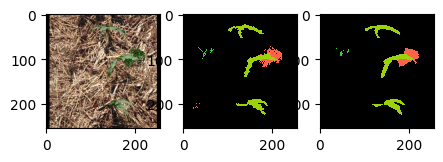

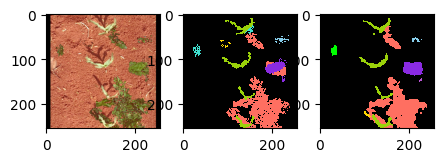

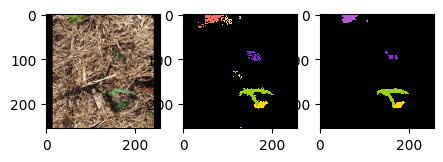

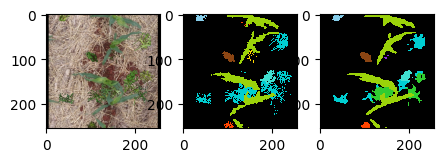

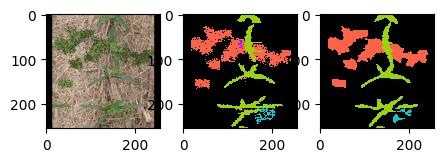

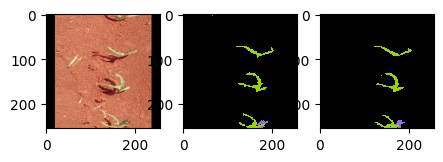

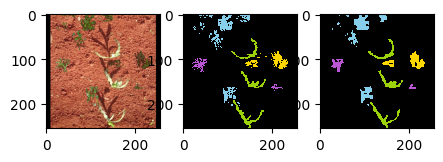

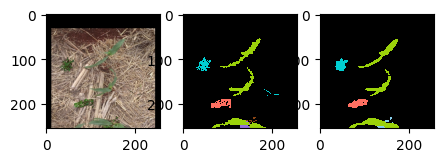

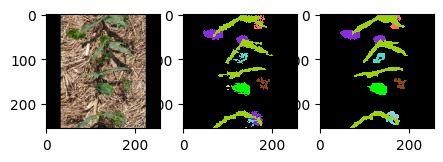

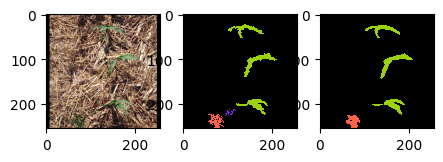

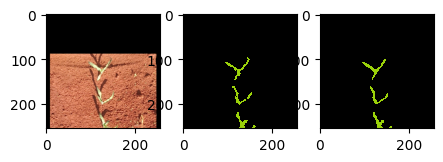

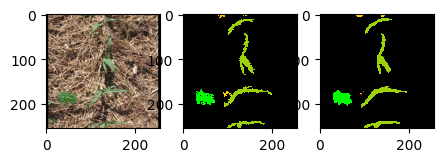

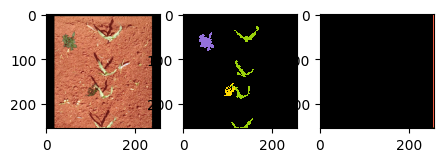

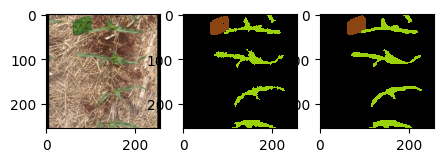

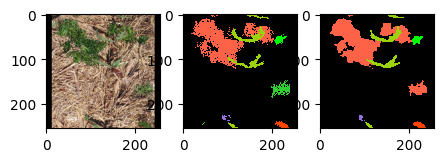

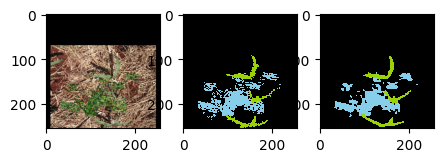

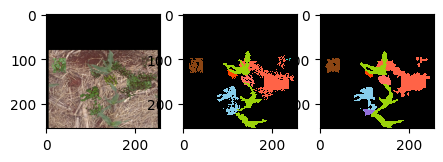

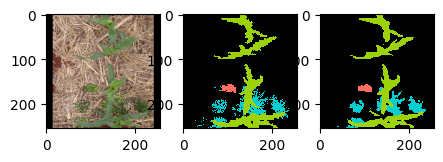

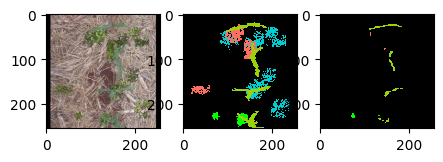

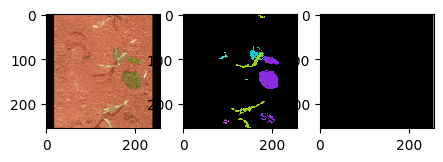

In [ ]:
DEVICE = 'cuda'

with torch.no_grad():
  for i in range(20):
    n = np.random.choice(len(test_dataset))
    image_vis = test_dataset_vis[n][0]
    # image_vis = image_vis*255
    # image_vis = image_vis.astype('uint8')

    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()

    x_tensor = image.to(DEVICE).unsqueeze(0).float()

    pr_mask = model.predict(x_tensor)
    m = nn.Softmax(dim=1)
    pr_probs = m(pr_mask)
    pr_mask = torch.argmax(pr_probs, dim=1).squeeze(1)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()

    _, axis = plt.subplots(1,3, figsize=(5,7))
    axis[0].imshow(image_vis)
    axis[1].imshow(gt_mask, cmap=cmap, vmin=0, vmax=len(colors)-1, interpolation='nearest')  # Convert to integer
    axis[2].imshow(pr_mask, cmap=cmap, vmin=0, vmax=len(colors)-1, interpolation='nearest')  # Convert to integer

## Cross Entropy

In [ ]:
from tqdm import tqdm as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ACTIVATION = None
MODE: str = 'multiclass'
LEARNING_RATE = 1e-4

criterion = nn.CrossEntropyLoss()

model = smp.PAN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels = 3,
    classes=len(CornWeedsDataset.CLASSES),
    activation=ACTIVATION
)

model.to(DEVICE)
num_classes = 16
iou_fn = MulticlassJaccardIndex(num_classes=num_classes, average=None).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss_meter = AvageraMeter()
val_loss_meter = AvageraMeter()
acc_meter = AvageraMeter()
iou_meter = AvageraMeter()
best_acc = 0

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:02<00:00, 94.9MB/s]


In [ ]:
for epoch in range(35):
    train_loss_meter.reset()
    val_loss_meter.reset()
    acc_meter.reset()

    for i, (inputs, labels) in enumerate(tqdm(train_data_loader)):
        optimizer.zero_grad()

        n = inputs.shape[1]
        inputs = inputs.to(DEVICE).float()
        labels = labels.to(DEVICE).long()

        outputs = model(inputs)
        labels = labels.squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            active_output = outputs.sigmoid().round().long()
            active_output = active_output.argmax(dim=1)
            train_loss_meter.update(loss.item(), n)
            acc_meter.update(accuracy_function(active_output, labels), n)
            iou_meter.update(iou_fn(active_output, labels.long()), n)

    print(f'epoch: {epoch}; loss: {train_loss_meter.avg}; accuracy: {acc_meter.avg}; iou: {iou_meter.avg}')

    if acc_meter.avg > best_acc:
        best_acc = acc_meter.avg
        print("saving model")
        torch.save(model.state_dict(), f'drive/My Drive/TCC/trained models/ce_cropped_model_2.pth')


  0%|          | 0/2185 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1d8ee76560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1d8ee76560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_worker

epoch: 0; loss: 0.2042879505172474; accuracy: 0.9082826972007751; iou: tensor([0.9148, 0.0339, 0.0212, 0.0454, 0.0412, 0.0301, 0.0872, 0.0348, 0.0129,
        0.0260, 0.0268, 0.0260, 0.0218, 0.0596, 0.0106, 0.0091],
       device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:34<00:00,  7.96it/s]


epoch: 1; loss: 0.1280876960409315; accuracy: 0.9136915802955627; iou: tensor([0.9179, 0.0460, 0.0396, 0.0595, 0.0626, 0.0550, 0.1301, 0.0577, 0.0181,
        0.0515, 0.0481, 0.0465, 0.0453, 0.0935, 0.0199, 0.0136],
       device='cuda:0')
saving model


100%|██████████| 2185/2185 [04:36<00:00,  7.91it/s]


epoch: 2; loss: 0.11396156715855718; accuracy: 0.917457103729248; iou: tensor([0.9202, 0.0577, 0.0521, 0.0699, 0.0790, 0.0729, 0.1602, 0.0799, 0.0238,
        0.0779, 0.0667, 0.0611, 0.0616, 0.1185, 0.0287, 0.0222],
       device='cuda:0')
saving model


 94%|█████████▍| 2052/2185 [04:19<00:16,  7.92it/s]


KeyboardInterrupt: 

In [ ]:

model.load_state_dict(torch.load('drive/My Drive/TCC/trained models/ce_cropped_model_2.pth'))
model.eval()
model.to(DEVICE)

test_dataset_vis = CornWeedsDataset(
  os.path.join(TEST_DATASET_PATH, 'images'),
  os.path.join(TEST_DATASET_PATH, 'annotations'),
)

In [ ]:
with torch.no_grad():
  for i in range(20):
    n = np.random.choice(len(test_dataset))
    image_vis = test_dataset_vis[n][0]
    # image_vis = image_vis*255
    # image_vis = image_vis.astype('uint8')

    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()

    x_tensor = image.to(DEVICE).unsqueeze(0).float()

    pr_mask = model.predict(x_tensor)
    m = nn.Softmax(dim=1)
    pr_probs = m(pr_mask)
    pr_mask = torch.argmax(pr_probs, dim=1).squeeze(1)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()

    _, axis = plt.subplots(1,3, figsize=(5,7))
    axis[0].imshow(image_vis)
    axis[1].imshow(gt_mask, cmap=cmap, vmin=0, vmax=len(colors)-1, interpolation='nearest')  # Convert to integer
    axis[2].imshow(pr_mask, cmap=cmap, vmin=0, vmax=len(colors)-1, interpolation='nearest')  # Convert to integer

## Using the blender dataset - CE loss

3 experimentos:

- roda na minha e testa na minha
- roda no dataset do blender e testa com o cornweeds
- Misturdo